# **N05. Unsupervised machine learning methods**

Apply different clustering methods for creating a labelled set.

In [84]:
#!pip install scikit-learn
#!pip install opencv-python 
import sklearn as sk
import random
import cv2
from astropy.io import fits
from matplotlib.colors import LogNorm


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import libraries.utilities as ut
# Plotting configuration.
mpl.rcParams["text.usetex"] = True
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["mathtext.fontset"] = "cm"  

# A. Objects I

Load samples

In [38]:
# Load headers.
image_headers = pd.DataFrame(pd.read_pickle("resources/metis_all25022025151324.pkl"))

In [71]:
# Load previously pre-classified objects.
OBJECTS = "resources/objects/objects_A.pkl"
possible_objects = pd.read_pickle(OBJECTS)
print(f"Total objects: {len(possible_objects)}")
print(f"Object shape: {possible_objects['REGION'].iloc[0].shape}")

# Convert into list elements.
images = possible_objects["REGION"].to_list()
file_names = possible_objects["FILENAME"].to_list()
x_cord = possible_objects["X_COORD"].to_list()
y_cord = possible_objects["Y_COORD"].to_list()

Total objects: 9519
Object shape: (11, 11)


Display samples

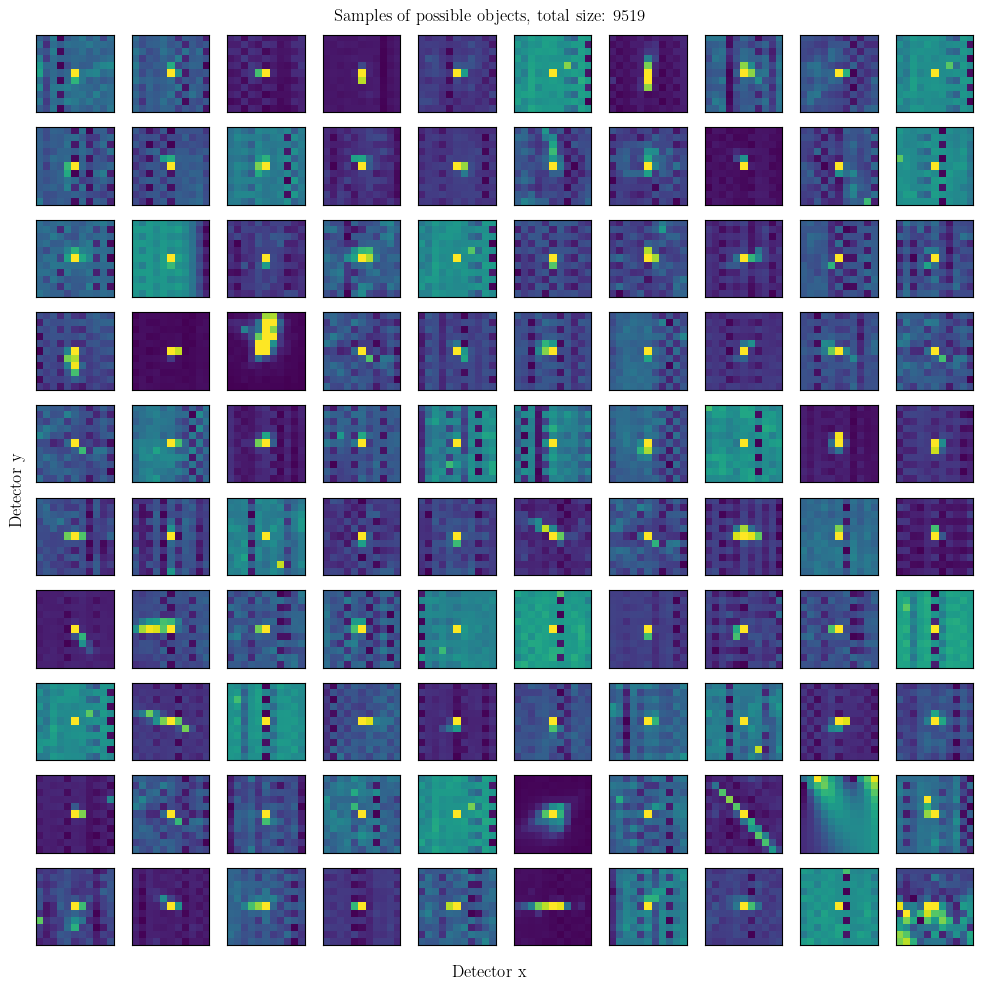

In [40]:
# Display several samples.
fig, axis = plt.subplots(10, 10, figsize =(10,10))
axis = axis.flatten()
fig.suptitle(f"Samples of possible objects, total size: {len(images)}")
fig.supxlabel("Detector x")
fig.supylabel("Detector y")
# Take samples.
indexes = np.random.randint(0, len(images), 100, dtype = int)

for i in range(100):
    j = indexes[i]
    axis[i].imshow(images[j])
    axis[i].set_xticks([]), axis[i].set_yticks([])
plt.tight_layout()

## **1. K-means**

Group data into k clusters based on feature similarity. Each cluster is defined by a centroid and points are grouped based on distance.

*Output:*

1. Compactness: sum of squared distances from each point into cluster center.
2. labels: array with labels with their corresponding cluster.
3. centers: coordinates of cluster center.

*Parameters:*

1. k -> number of clusters.
2. bestLabels -> randomly assignment of label at start.
3. criteria -> max iteration reached, accuracy is reached, max iteration, if centers move less than 1.0 (epsilon).
4. attempts -> number of times k-means will be executed. Best result with lowest compactness is returned.
5. flags -> initialization for cluster center.

**Define principal functions**

In [41]:
def k_means_nn(vectors, clusters, attempts, criteria):
    """
    Group data into K clusters based on feature similarity.

    Parameters:
        vectors (array): array with vectors to be analyzed. 
        clusters (int): number of assigned clusters.
        criteria (tuple): max number of iterations and accuracy.
        attempts (int): number of times k-means will be executed.

    Return:
        compactness (float): sum of squared distances from each point into cluster center.
        labels (list): list with obtained clusters labels.
        centers (list): coordinates of cluster centers.

    """

    compactness, labels, centers = cv2.kmeans(data=vectors.astype(np.float32),
                                          K=clusters,
                                          bestLabels=None,
                                          criteria=criteria,
                                          attempts=attempts,
                                          flags=cv2.KMEANS_PP_CENTERS)

    return compactness, labels, centers

**Run code**

In [42]:
# Flatten images.
images = np.array([img.flatten() for img in images])
print(f"Final size of vectors: {images.shape}")

Final size of vectors: (9519, 121)


In [43]:
### K-means parameters.
CRITERIA = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 1000, 0.01)
CLUTERS = 10
ATTEMPTS = 12

# Test 1
compactness_1, labels_1, centers_1 = k_means_nn(images, CLUTERS, ATTEMPTS, CRITERIA)

**Display reference image**

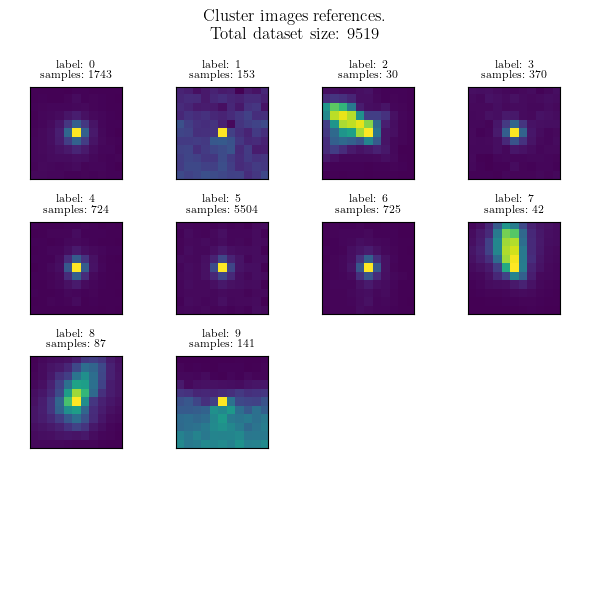

In [44]:
def kmeans_reference(centers, labels, original_shape = 11):  
    """
    Display reference image and number of samples for each cluster.

    Parameters:
        centers (list): list with a referential image for each obtained cluster.
        labels (array): array with obtained cluster labels.
        original_shape (int): original height of the images. 
    """
    # Extract number of samples per cluster.
    unique, counts = np.unique(labels_1, return_counts=True)

    # Extract reference image and reshape.
    references = [img.reshape(original_shape,original_shape) for img in centers]

    # Create plot.
    n = int(np.ceil(np.sqrt(len(centers))))
    fig, axis = plt.subplots(n, n, figsize = (int(1.5*n), int(1.5*n)))
    axis = axis.flatten()
    fig.suptitle(f"Cluster images references. \n Total dataset size: {len(labels_1)}")

    # Plot each cluster referential image.
    for idx, img in enumerate(references):
        axis[idx].set_title(f"label: {idx} \n samples: {counts[idx]}", fontsize = 8)
        axis[idx].imshow(img)
        axis[idx].set_xticks([]), axis[idx].set_yticks([])

    for i in range(len(references), len(axis)):
            axis[i].axis('off')
    plt.tight_layout()

kmeans_reference(centers_1, labels_1)

**Display samples**

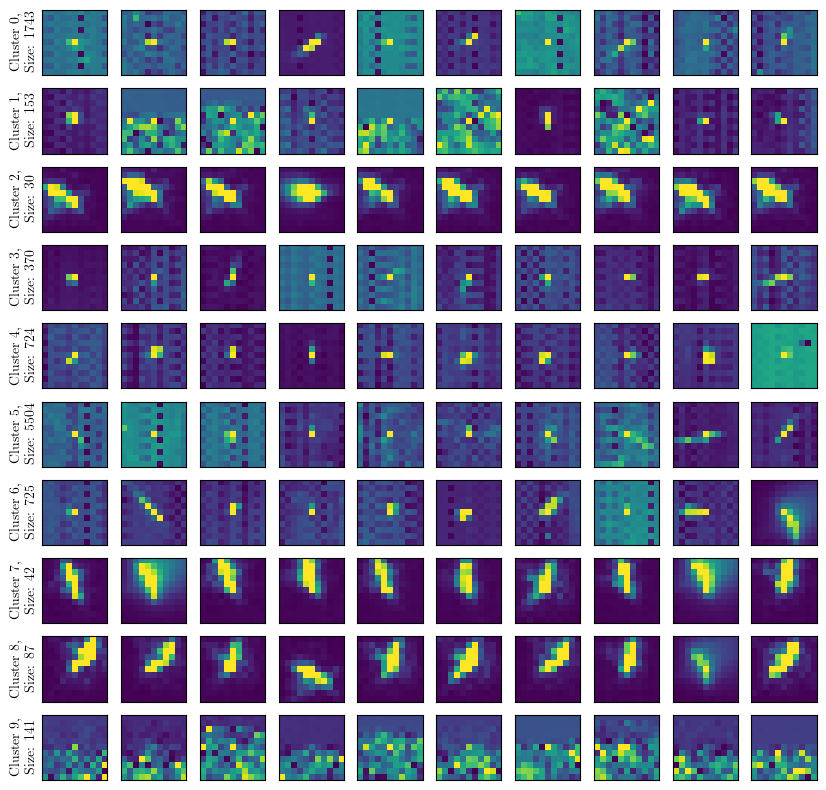

In [45]:
def kmeans_sample(images, labels, n_samples, original_shape = 11):  
    """
    Display samples for each obtained cluster from K-means algorithm.

    Parameters:
        images (list): flatten input images.
        labels (array): array with obtained cluster labels.
        n_samples (int): number of samples to plot from each cluster.    
        original_shape (int): original height of the input image.
    """
    # Extract clusters.
    unique, counts = np.unique(labels, return_counts=True)

    # Merge images with respective labels.
    pairs = list(zip(images, labels))

    # Create plot.
    fig, axis = plt.subplots(len(unique), n_samples, figsize = (10, 10))

    for i in range(len(unique)):
        samples = [img.reshape(original_shape,original_shape) for img, lbl in pairs if lbl == i]
        samples_r = random.sample(samples, n_samples)
        axis[i,0].set_ylabel(f"Cluster {i}, \n Size: {len(samples)}")
        for j in range(n_samples):
            axis[i, j].imshow(samples_r[j])
            axis[i, j].set_xticks([])
            axis[i, j].set_yticks([])

kmeans_sample(images, labels_1, 10)

Check original files

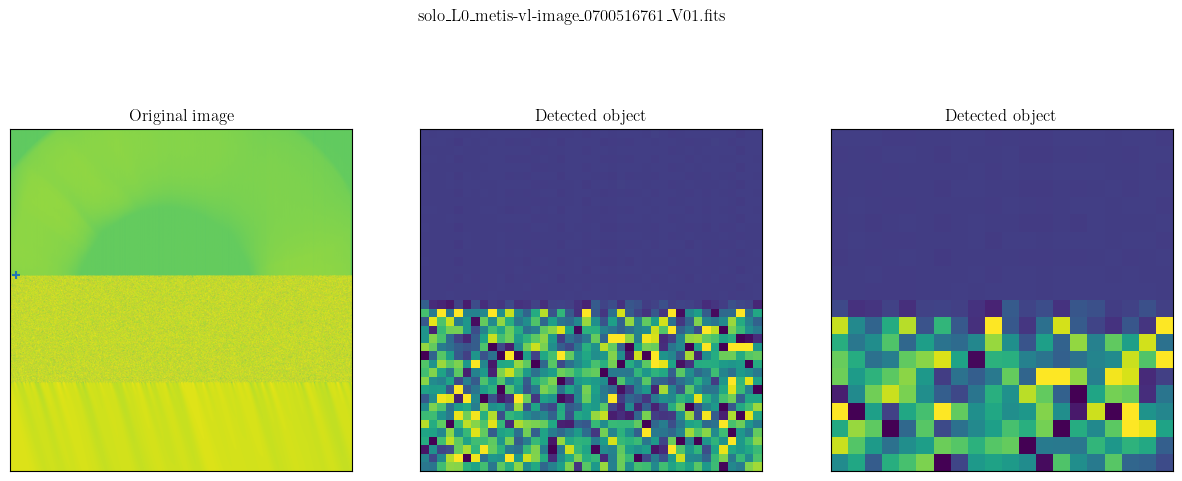

In [93]:
def object_to_fits(images, labels, filenames, x_cord, y_cord, headers, cluster_index):
    """
    Given a detected object, find the original FITS file and display its original position in the image.
    """

    # Create new list with all labels, imgs and file name.
    img_keys = list(zip(images, labels_1, file_names, x_cord, y_cord))
    # Search image filename.

    indices = [i for i, tup in enumerate(img_keys) if cluster_index in tup[1]]
    filename = img_keys[indices[0]][2]

    # Search url in file headers.
    url_found = image_headers[image_headers['url'].str.contains(filename)]
    ut.download_fits(url_found["url"].iloc[0], "found.fits", ".")

    # Start plotting.
    x = img_keys[indices[0]][3]
    y = img_keys[indices[0]][4]

    file = fits.open("found.fits")
    fig, axis = plt.subplots(1, 3, figsize = (15, 6))
    axis[0].imshow(file[0].data, norm = LogNorm() )
    axis[1].imshow(file[0].data[y-20:y+20, x-20:x+20])
    axis[2].imshow(file[0].data[y-10:y+10, x-10:x+10])
    axis[0].set_xticks([]), axis[0].set_yticks([])
    axis[1].set_xticks([]), axis[1].set_yticks([])
    axis[2].set_xticks([]), axis[2].set_yticks([])
    
    fig.suptitle(filename)
    axis[0].set_title("Original image")
    axis[0].scatter(x, y, marker = "+")
    axis[1].set_title("Detected object")
    axis[2].set_title("Detected object")

object_to_fits(images, labels_1, file_names, x_cord, y_cord, image_headers, 9)

## **2. Density-Based Spatial Clustering of Aplications with Noise (DBSCAN)**

Group together points that are densely packed together and labels points in low-density as outliers.


*Parameters:*
1. eps: maximum distance between two samples for them to be considered neighbors.
2. min_samples: minimum number of neighbors (including point itself) to form a dense region.

*Output:*

1. labels: -1 if it is noise, and int if it belongs to a cluster.

**Define principal function**

In [14]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

def dbscan(samples, eps, min_samples):
    """
        Density-based Spatial Clustering of Aplications with Noise (DBSCAN) groups together points that are densely packed together.

        Parameters:
            samples (list): flattened images to be analyzed.
            eps (float): maximum distance between two samples to be consider neighbors.
            min_samples (int): maximum number of neighbors to form a dense region.
        
        Output:
            labels (list): cluster indexes: -1 -> noise; !-1 -> cluster index.
    """
    dbscan = DBSCAN(eps = eps, min_samples= min_samples)
    labels = dbscan.fit_predict(samples)

    return labels

**Get best eps**

Find the best "eps" (maximum distance for two samples to be considered neighbors in DBSCAN).

First, take a value for k (4-5) and for every data point, find the distance to its k-th nearest neighbor. Finally plot distances in increasing order.

Then, look for an elbow. Before this point, points are densely packed.

In [15]:
# Scale PSFs.
scaled_images = StandardScaler().fit_transform(images)
print(f"Final size of vectors: {scaled_images.shape}")

Final size of vectors: (9519, 121)


In [16]:
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator

def dbscan_eps_finder(images, k_neighbord):
    """
    Find best eps for DBSCAN algorithm.

    Parameters:
        images (numpy): flatten images to be analyzed.
        k_neighbor (int): kth closest neighbor.

    Output:
        distances (array): ordered array with distances of each point to its kth neighbor.
        eps (float): optimal eps for the given configuration.
    """

    # Set kth neighbor.
    neigh = NearestNeighbors(n_neighbors=k_neighbord)
    nbrs = neigh.fit(images)
    distances, _ = nbrs.kneighbors(images)

    # Compute distances from every point to its kth neighbor.
    distances = np.sort(distances[:, k_neighbord-1])

    # Extraxt knee.
    knee = KneeLocator(range(len(distances)), distances, curve='convex', direction='increasing')
    eps = knee.knee

    return distances, eps

Compute optimal eps.

Knee detected at: 25.803287742402006


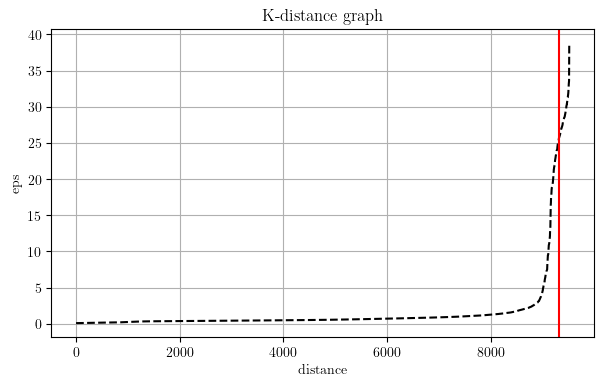

In [17]:
MIN_SAMPLES = 30
distances, eps = dbscan_eps_finder(scaled_images, MIN_SAMPLES )

# Display plot.
fig, axis = plt.subplots(1, 1, figsize = (7, 4))
axis.plot(distances, color = "black", linestyle = "dashed")
axis.set_title("K-distance graph")
axis.set_xlabel("distance")
axis.set_ylabel("eps")
axis.grid()
axis.axvline(eps, color = "red")
print(f"Knee detected at: {distances[eps]}")

**Run code**

In [18]:
# Run DBSCAN
EPS = 25
MIN_SAMPLES = 30
labels_2 = dbscan(scaled_images, EPS, MIN_SAMPLES)

**Display samples**

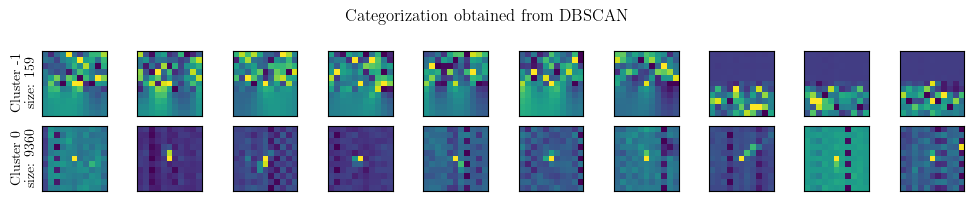

In [19]:
def dbscan_samples(images, labels, n_samples, original_shape = 11):
    """
    Display obtained cluster and samples from DBSCAN algorithm.

    Parameters:
        images (list): list with flattened images.
        labels (list): obtained list with labels from dbscan algorithm.
        n_samples (int): number of samples to be displayed for each cluster.
        original_shape (int): original height of the images.
    """

    # Count labels and occurrences.
    unique, counts = np.unique(labels, return_counts=True)
    # Create pairs.
    pairs = list(zip(images, labels))
    fig, axis = plt.subplots(len(unique), n_samples, figsize = (n_samples, len(unique)))
    fig.suptitle("Categorization obtained from DBSCAN")

    for i in range(len(unique)):
        samples = [img.reshape(original_shape,original_shape) for img, lbl in pairs if lbl == i-1]

        for j in range(n_samples):
            axis[i,0].set_ylabel(f"Cluster {i-1} \n size: {len(samples)}")
            try:
                axis[i,j].imshow(samples[j])
                axis[i,j].set_xticks([])
                axis[i,j].set_yticks([])
            except:
                print(f"No enough samples for cluster: {i-1}")
                axis[i,j].axis("off")
    plt.tight_layout()
    
dbscan_samples(images, labels_2, 10, 11)


In [20]:
def dbscan_samples_cluster(samples, index, n_samples = 100):
    """
    Display DBSCAN samples that belong to an specific cluster index.

    Parameters:
        samples (list): pairs with flatten image and cluster index.
        index (int): cluster label to be displayed.
        n_samples (int): number of samples to be displayed.

    """

    # Create plot.
    n = int(np.sqrt(n_samples))
    fig, axis = plt.subplots(n, n, figsize = (n, n))
    fig.suptitle(f"PSFs with cluster: {index}")
    axis = axis.flatten()

    # Reshape images to original size.
    raw_samples = [img.reshape(11, 11) for img, lbl in samples if lbl == index]

    # Check if number of required images exist.
    if len(raw_samples) >= n_samples:
        samples = random.sample(raw_samples, n_samples)
    else:
        samples = raw_samples
        
    
    # Plot images.
    for i in range(len(samples)):
        axis[i].imshow(samples[i])
        axis[i].set_xticks([])
        axis[i].set_yticks([])
    # Delete axes for non plotted images.
    for i in range(len(samples), n**2):
        axis[i].axis("off")
    
    plt.tight_layout()
    print(f"Number of samples: {len(raw_samples)}")

In [21]:
possible_objects

,LTP,STP,IDX,PEAK_VAL,X_COORD,Y_COORD,PRE_LABEL,INFO,REGION,FILENAME,PEAK RANGE,FILTER 1,FILTER 2 N,FILTER 2 P,FILTER 3 N,FILTER 4 R
1,LTP5,STP180,5,1891.0,322,23,object,info,"[[1590, 1707, 1683, 1690, 1696, 1681, 1671, 16...",solo_L0_metis-vl-image_0691915736_V01.fits,group1,True,2,"[[5, 5], [6, 8]]",1,0.5
31,LTP5,STP180,5,2397.0,1190,250,object,info,"[[1813, 1832, 1734, 1815, 1831, 1771, 1807, 18...",solo_L0_metis-vl-image_0691915736_V01.fits,group2,True,2,"[[4, 5], [5, 5]]",1,0.0
41,LTP5,STP180,5,2225.0,1135,265,object,info,"[[1799, 1799, 1820, 1804, 1793, 1799, 1712, 18...",solo_L0_metis-vl-image_0691915736_V01.fits,group2,True,2,"[[5, 5], [6, 5]]",1,0.0
67,LTP5,STP180,5,2119.0,148,449,object,info,"[[1668, 1667, 1680, 1654, 1649, 1669, 1683, 16...",solo_L0_metis-vl-image_0691915736_V01.fits,group2,True,2,"[[5, 4], [5, 5]]",1,0.0
97,LTP5,STP180,5,2021.0,1981,689,object,info,"[[1735, 1748, 1767, 1766, 1681, 1693, 1751, 16...",solo_L0_metis-vl-image_0691915736_V01.fits,group2,True,2,"[[5, 5], [6, 6]]",1,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350833,LTP15,STP301,27,3103.0,1361,1489,object,info,"[[2310, 2302, 2312, 2296, 2279, 2296, 2292, 22...",solo_L0_metis-vl-image_0764165525_V01.fits,group3,True,2,"[[5, 5], [5, 6]]",1,0.0
350849,LTP15,STP301,27,2718.0,214,1664,object,info,"[[2358, 2418, 2468, 2416, 2451, 2441, 2403, 24...",solo_L0_metis-vl-image_0764165525_V01.fits,group2,True,2,"[[5, 4], [5, 5]]",2,0.0
351023,LTP15,STP301,29,2488.0,76,257,object,info,"[[2074, 2108, 2087, 2096, 2082, 2113, 2110, 21...",solo_L0_metis-vl-image_0764166394_V01.fits,group2,True,2,"[[5, 5], [5, 6]]",1,0.0
351110,LTP15,STP301,29,2856.0,307,1656,object,info,"[[2433, 2460, 2427, 2426, 2468, 2439, 2480, 24...",solo_L0_metis-vl-image_0764166394_V01.fits,group2,True,2,"[[5, 5], [5, 6]]",1,0.0


Display "noisy samples"

Number of samples: 159


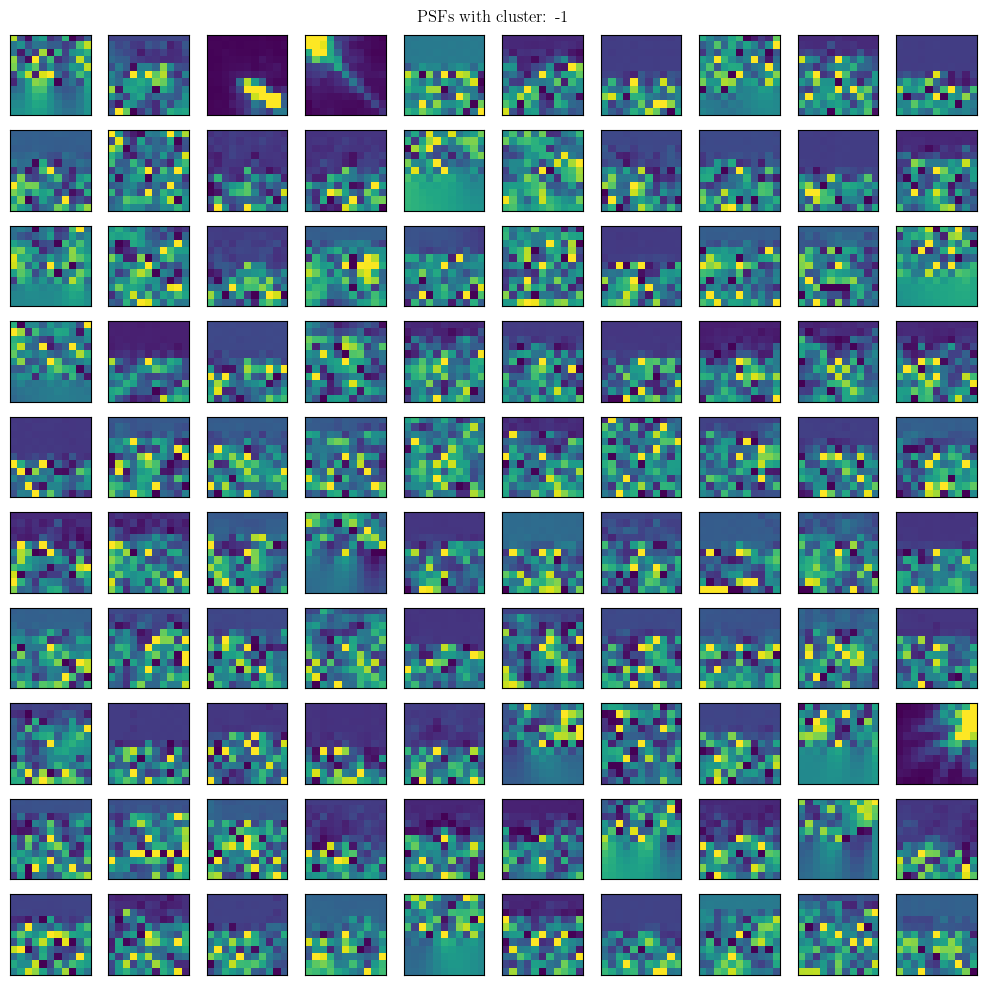

In [22]:
# Create pairs.
pairs = list(zip(images, labels_2))

# Display possible noise.
dbscan_samples_cluster(pairs, -1, 100)

Display possible cluster samples.

Number of samples: 9360


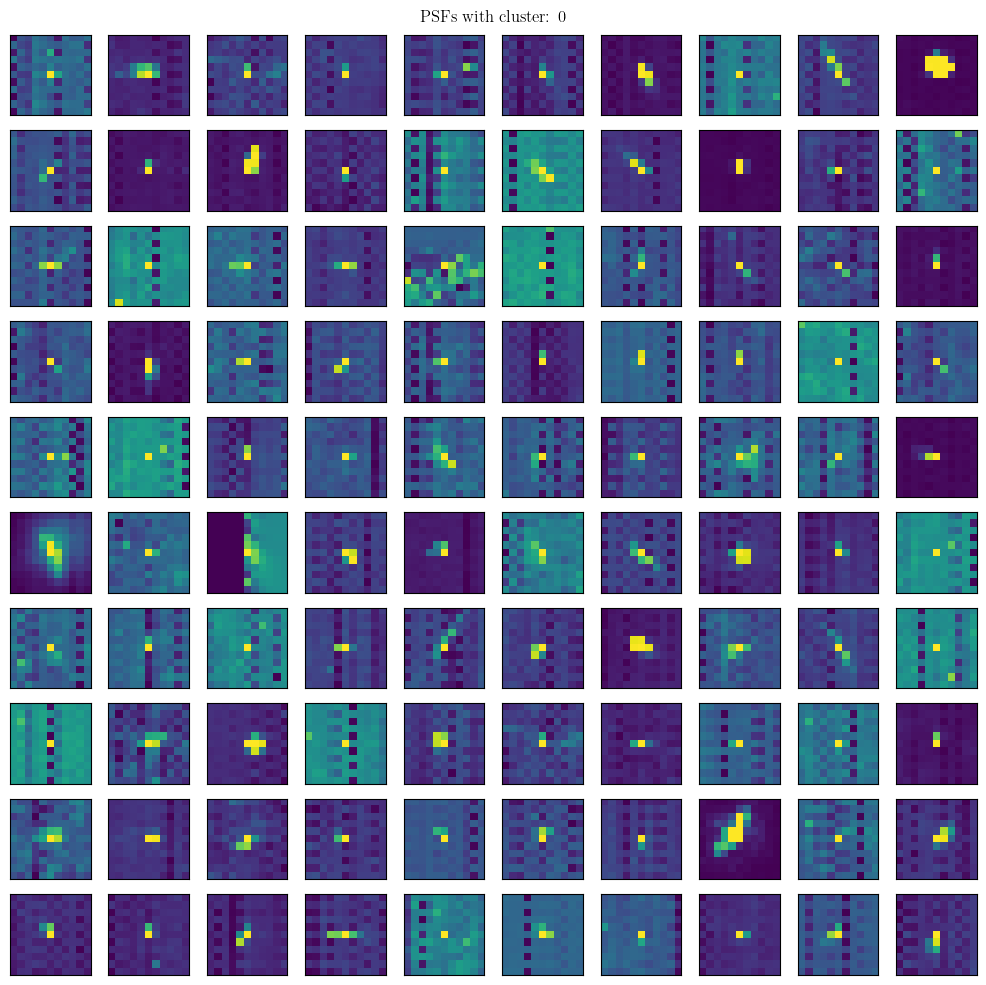

In [23]:
# Display cluster 0.
dbscan_samples_cluster(pairs, 0, 100)

## **3. Principal component analysis (PCA)**



Dimensionality reduction technique that transforms high-dimensional data into smaller number of dimensions without losing relevant information.


**Check for Number of components**

Display how much variance each component explains. Select a number of components that preserve as much variance possible but also reducing the dimensionality. 

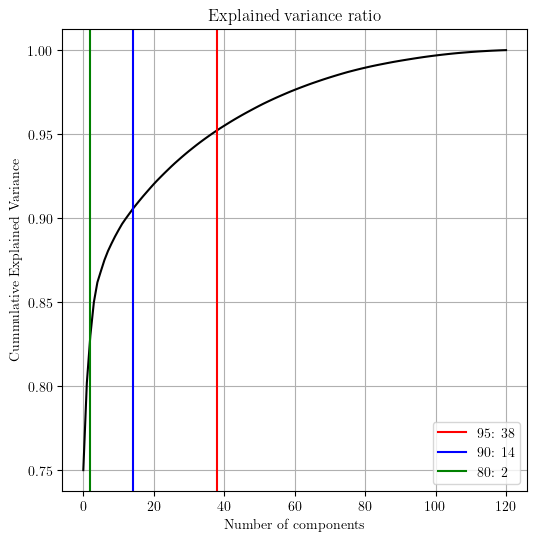

In [24]:
from sklearn.decomposition import PCA

# Check number of components for the previously flatten and scaled PSFs.
pca = PCA(n_components= len(scaled_images[0]))
# Apply dimensionality reduction.
psfs_pca = pca.fit_transform(scaled_images)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
# Take number of component that preserves 95% of information.
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
n_components_80 = np.argmax(cumulative_variance >= 0.80) + 1


# Display Cummulative Explained variance.
fig, axis = plt.subplots(1, 1, figsize = (6, 6))
axis.plot(np.cumsum(pca.explained_variance_ratio_), color ="black")
axis.grid()
axis.set_xlabel("Number of components")
axis.set_ylabel("Cummulative Explained Variance")
axis.set_title("Explained variance ratio")
axis.axvline(n_components_95, color ="red", label = f"95: {n_components_95}")
axis.axvline(n_components_90, color ="blue", label = f"90: {n_components_90}")
axis.axvline(n_components_80, color ="green", label = f"80: {n_components_80}")
axis.legend()

### 3.1 K-means with PCA.

**n components PCA = 95**

Compactness: 168178.3438775614


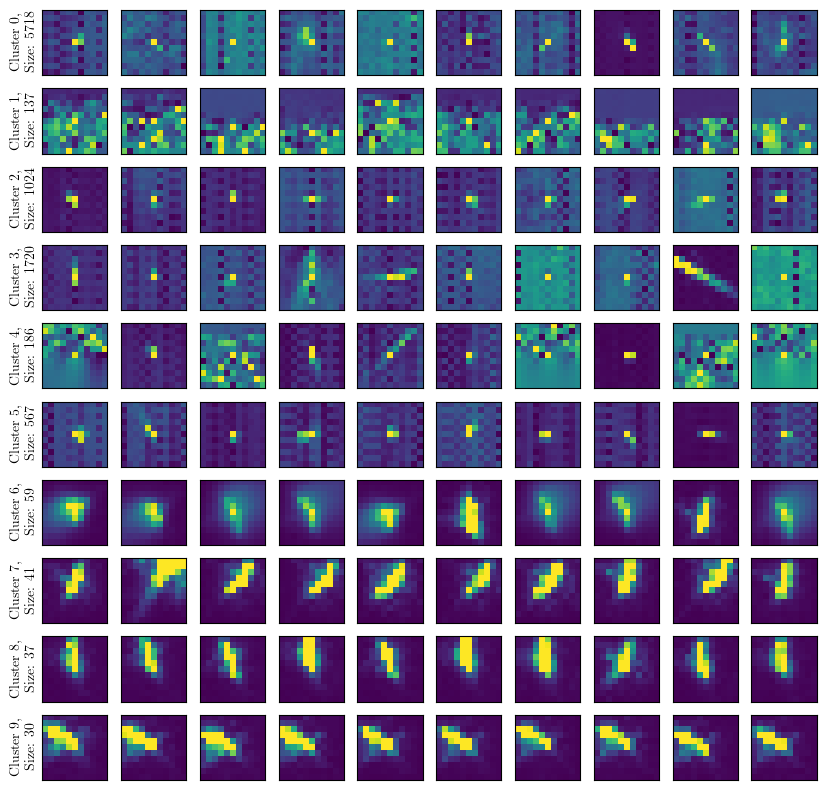

In [25]:
# Apply PCA with 95% of information retaining.
pca = PCA(n_components= n_components_95)
pca_images = pca.fit_transform(scaled_images)

# K-means parameters.
CRITERIA = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 1000, 0.01)
CLUSTERS = 10
ATTEMPTS = 12

# Run model.
compactness_1pca, labels_1pca, centroids_1pca = k_means_nn(pca_images, CLUSTERS, ATTEMPTS, CRITERIA)

# Display samples.
kmeans_sample(images, labels_1pca, 10)
print(f"Compactness: {compactness_1pca}")

**n components PCA = 90**

Compactness: 112870.6128821848


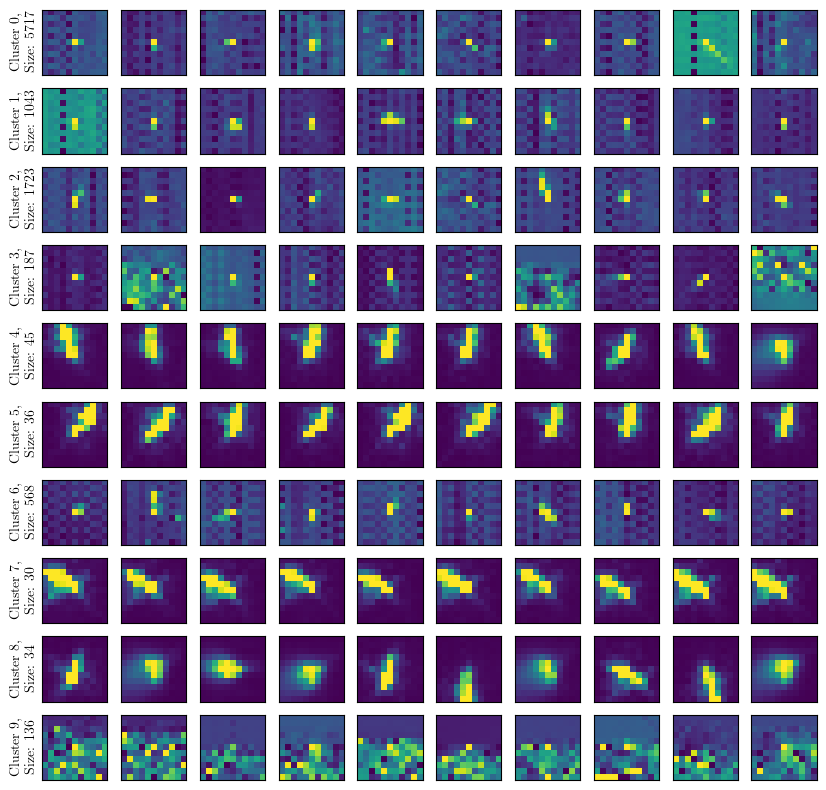

In [26]:
# Apply PCA with 90% of information retaining.
pca = PCA(n_components= n_components_90)
pca_images = pca.fit_transform(scaled_images)

# K-means parameters.
CRITERIA = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 1000, 0.01)
CLUSTERS = 10
ATTEMPTS = 12

# Run model.
compactness_2pca, labels_2pca, centroids_2pca = k_means_nn(pca_images, CLUSTERS, ATTEMPTS, CRITERIA)

# Display samples.
kmeans_sample(images, labels_2pca, 10)
print(f"Compactness: {compactness_2pca}")

**n components PCA = 80**

Compactness: 30992.48246373485


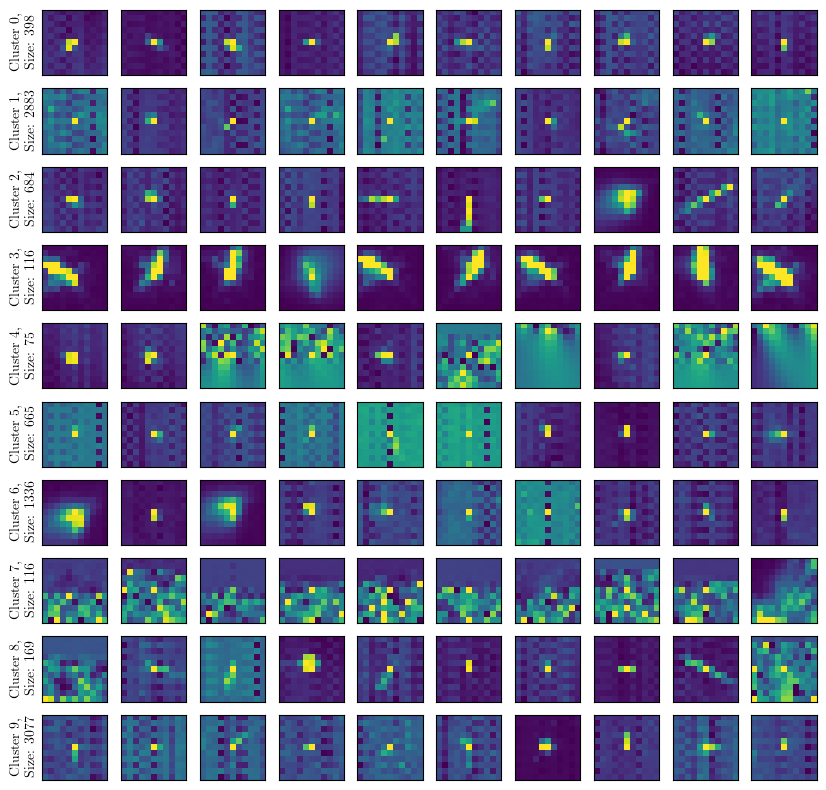

In [27]:
# Apply PCA with 80% of information retaining.
pca = PCA(n_components= n_components_80)
pca_images = pca.fit_transform(scaled_images)

# K-means parameters.
CRITERIA = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 1000, 0.01)
CLUSTERS = 10
ATTEMPTS = 12

# Run model.
compactness_3pca, labels_3pca, centroids_3pca = k_means_nn(pca_images, CLUSTERS, ATTEMPTS, CRITERIA)

# Display samples.
kmeans_sample(images, labels_3pca, 10)
print(f"Compactness: {compactness_3pca}")

### 3.2 DBSCAN with PCA.

**n components PCA = 95**

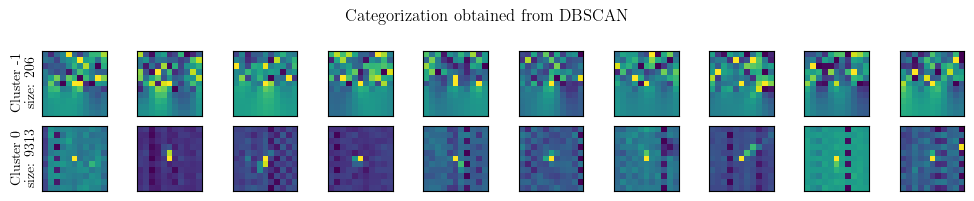

In [28]:
# Apply PCA with 95% of information retaining.
pca = PCA(n_components= n_components_95)
pca_images = pca.fit_transform(scaled_images)

# Find optimal eps.
MIN_SAMPLES = 5
distances, eps = dbscan_eps_finder(pca_images, MIN_SAMPLES )

# Run dbscan.
labels_95 = dbscan(scaled_images, distances[eps], MIN_SAMPLES)

# Display samples.
dbscan_samples(images, labels_95, 10, 11)


**n components PCA = 90**

No enough samples for cluster: 1
No enough samples for cluster: 1
No enough samples for cluster: 1
No enough samples for cluster: 1
No enough samples for cluster: 1
No enough samples for cluster: 4
No enough samples for cluster: 4
No enough samples for cluster: 4
No enough samples for cluster: 4
No enough samples for cluster: 6
No enough samples for cluster: 6
No enough samples for cluster: 6
No enough samples for cluster: 6


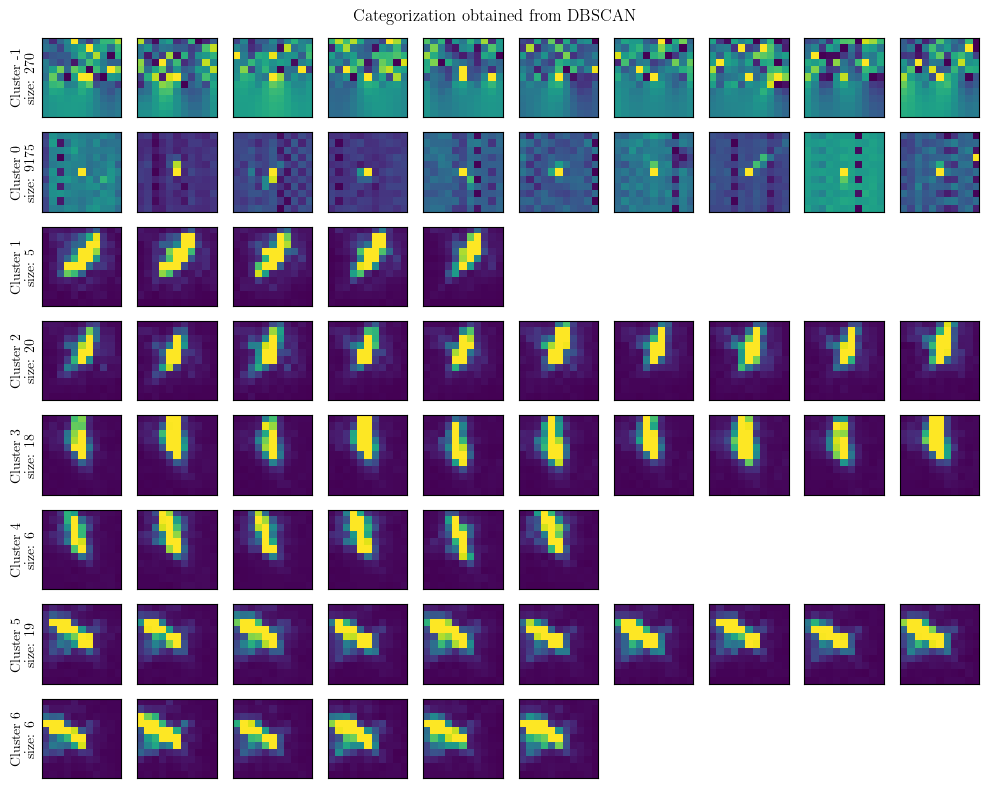

In [29]:
# Apply PCA with 90% of information retaining.
pca = PCA(n_components= n_components_90)
pca_images = pca.fit_transform(scaled_images)

# Find optimal eps.
MIN_SAMPLES = 5
distances, eps = dbscan_eps_finder(pca_images, MIN_SAMPLES )

# Run dbscan.
labels_90 = dbscan(scaled_images, distances[eps], MIN_SAMPLES)

# Display samples.
dbscan_samples(images, labels_90, 10, 11)

**n components PCA = 80**

No enough samples for cluster: 1
No enough samples for cluster: 1
No enough samples for cluster: 1
No enough samples for cluster: 1
No enough samples for cluster: 2
No enough samples for cluster: 2
No enough samples for cluster: 2
No enough samples for cluster: 2
No enough samples for cluster: 2


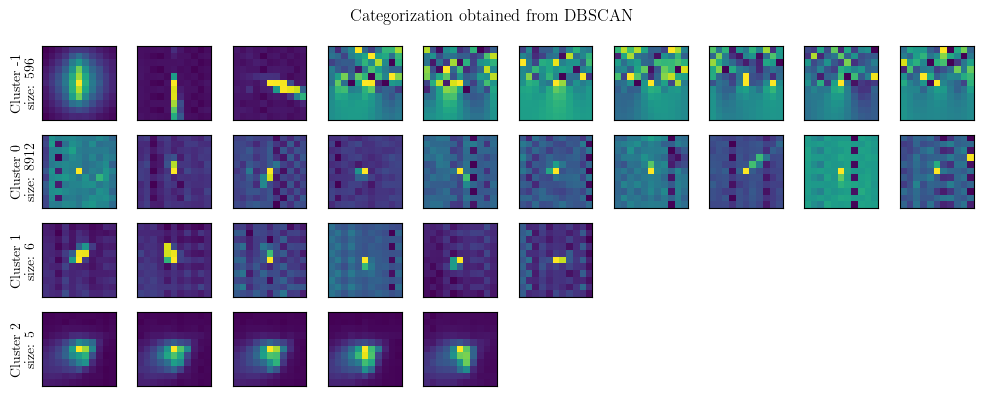

In [30]:
# Apply PCA with 90% of information retaining.
pca = PCA(n_components= n_components_80)
pca_images = pca.fit_transform(scaled_images)

# Find optimal eps.
MIN_SAMPLES = 5
distances, eps = dbscan_eps_finder(pca_images, MIN_SAMPLES )

# Run dbscan.
labels_80 = dbscan(scaled_images, distances[eps], MIN_SAMPLES)

# Display samples.
dbscan_samples(images, labels_80, 10, 11)

# B. Objects II

In [31]:
# Load previously pre-classified objects.
OBJECTS = "resources/objects/objects_B.pkl"
possible_objects = pd.read_pickle(OBJECTS)
print(f"Total objects: {len(possible_objects)}")
print(f"Object shape: {possible_objects['REGION'].iloc[0].shape}")

# Convert into list elements.
images = possible_objects["REGION"].to_list()
# Flatten images.
images = np.array([img.flatten() for img in images])
# Standarize images.
scaled_images = StandardScaler().fit_transform(images)

Total objects: 4124
Object shape: (15, 15)


## **1. PCA Principal component analysis**

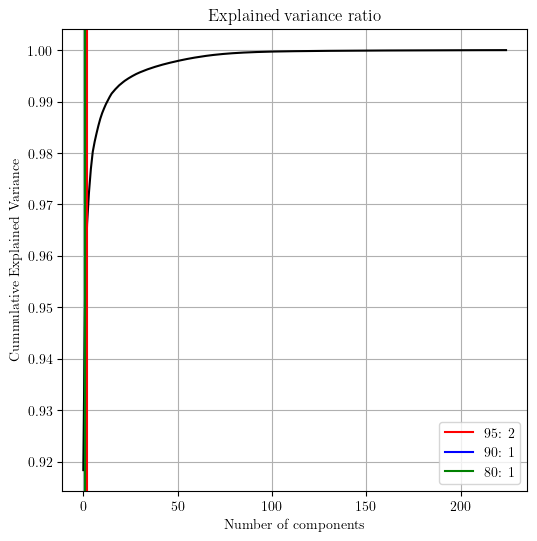

In [32]:
# Check number of components for the previously flatten and scaled PSFs.
pca = PCA(n_components= len(scaled_images[0]))

# Apply dimensionality reduction.
psfs_pca = pca.fit_transform(scaled_images)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
# Take number of component that preserves 95% of information.
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
n_components_80 = np.argmax(cumulative_variance >= 0.80) + 1


# Display Cummulative Explained variance.
fig, axis = plt.subplots(1, 1, figsize = (6, 6))
axis.plot(np.cumsum(pca.explained_variance_ratio_), color ="black")
axis.grid()
axis.set_xlabel("Number of components")
axis.set_ylabel("Cummulative Explained Variance")
axis.set_title("Explained variance ratio")
axis.axvline(n_components_95, color ="red", label = f"95: {n_components_95}")
axis.axvline(n_components_90, color ="blue", label = f"90: {n_components_90}")
axis.axvline(n_components_80, color ="green", label = f"80: {n_components_80}")
axis.legend()

## **2. K-means**

### 10 clusters.

**PCA with 10 components**

Compactness: 48369.26099327952


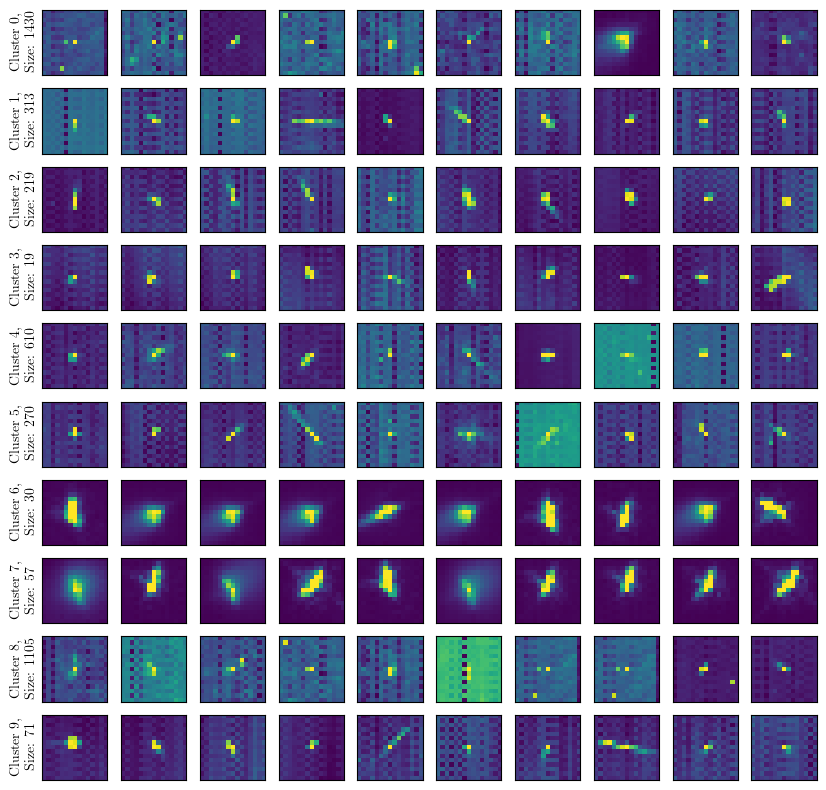

In [33]:
# Apply PCA with 10 components.
pca = PCA(n_components= 10)
pca_images = pca.fit_transform(scaled_images)

# K-means parameters.
CRITERIA = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 1000, 0.01)
CLUSTERS = 10
ATTEMPTS = 12

# Run model.
compactness_1pca, labels_1pca, centroids_1pca = k_means_nn(pca_images, CLUSTERS, ATTEMPTS, CRITERIA)

# Display samples.
kmeans_sample(images, labels_1pca, 10, original_shape= 15)
print(f"Compactness: {compactness_1pca}")

**PCA with 5 components**

Compactness: 39378.13673464302


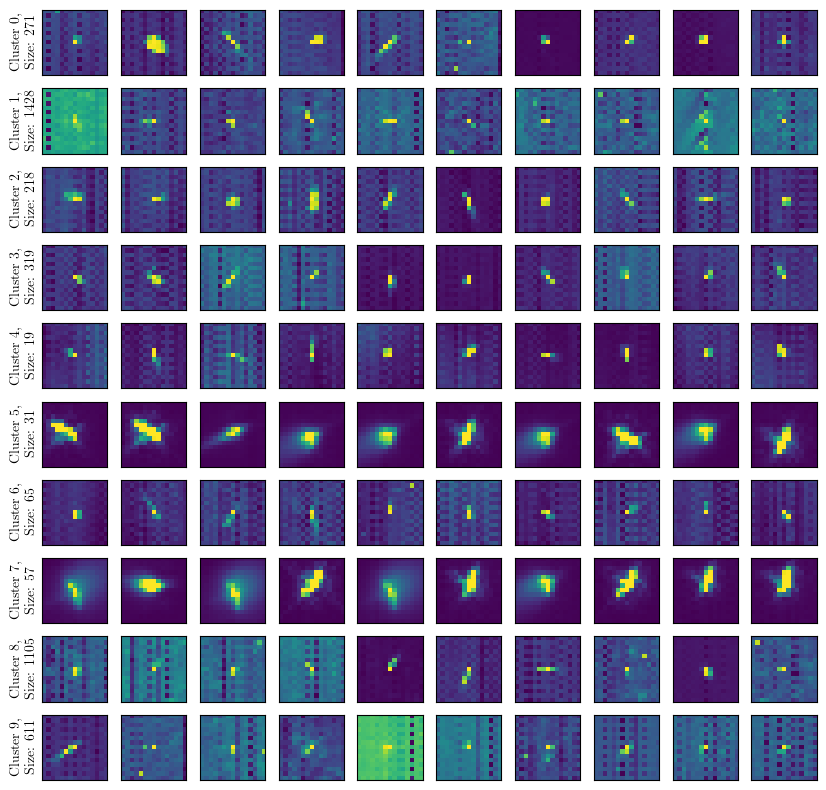

In [34]:
# Apply PCA with 10 components.
pca = PCA(n_components= 5)
pca_images = pca.fit_transform(scaled_images)

# K-means parameters.
CRITERIA = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 1000, 0.01)
CLUSTERS = 10
ATTEMPTS = 12

# Run model.
compactness_2pca, labels_2pca, centroids_2pca = k_means_nn(pca_images, CLUSTERS, ATTEMPTS, CRITERIA)

# Display samples.
kmeans_sample(images, labels_2pca, 10, original_shape= 15)
print(f"Compactness: {compactness_2pca}")

**PCA with 2 components**

Compactness: 78352.87883326254


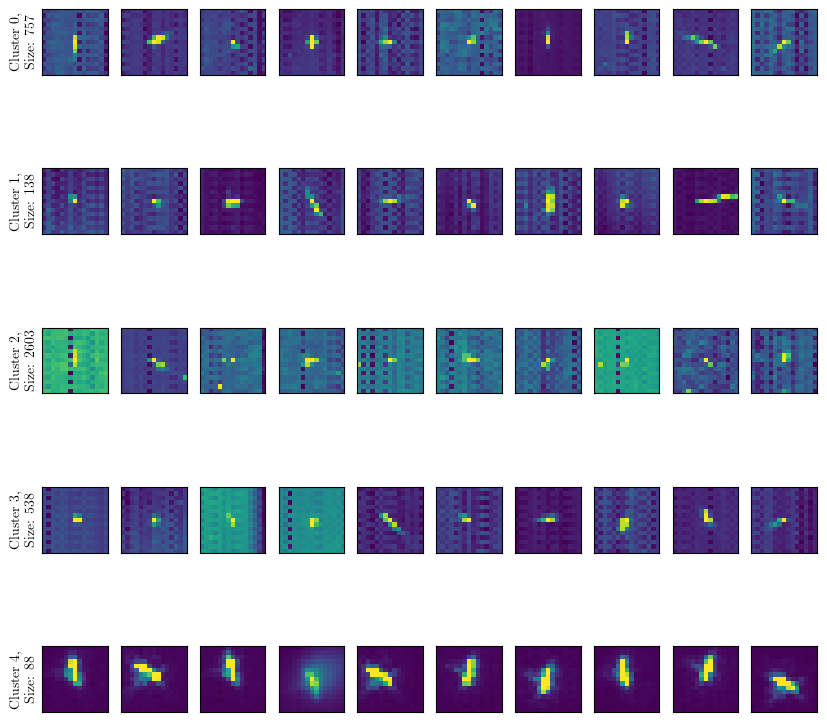

In [35]:
# Apply PCA with 2 components.
pca = PCA(n_components=2)
pca_images = pca.fit_transform(scaled_images)

# K-means parameters.
CRITERIA = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 1000, 0.01)
CLUSTERS = 5
ATTEMPTS = 12

# Run model.
compactness_3pca, labels_3pca, centroids_3pca = k_means_nn(pca_images, CLUSTERS, ATTEMPTS, CRITERIA)

# Display samples.
kmeans_sample(images, labels_3pca, 10, original_shape= 15)
print(f"Compactness: {compactness_3pca}")

Text(0.5, 1.0, 'PSFs clusters with 2 features.')

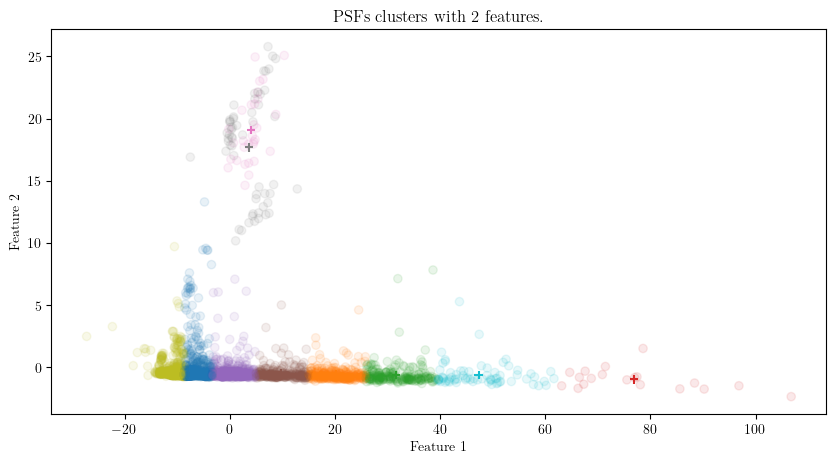

In [36]:
fig, axis = plt.subplots(1, 1, figsize = (10, 5))

axis.scatter(pca_images[:,0], pca_images[:,1],c = labels_1pca, cmap="tab10", alpha = 0.1)
axis.scatter(centroids_1pca[:,0], centroids_1pca[:,1], c = np.arange(10), cmap = "tab10", marker = "+")
axis.set_xlabel("Feature 1"), axis.set_ylabel("Feature 2")
axis.set_title("PSFs clusters with 2 features.")

### Compactness analysis with 2 components

Text(0.5, 1.0, 'Optimization for number of clusters with 2 components.')

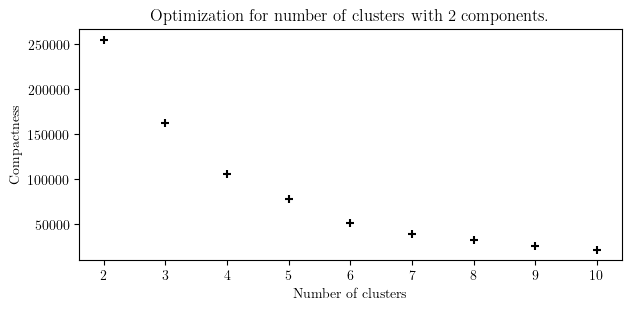

In [37]:
# K-means parameters.
n_clusters = np.arange(2,11)
compactness_values = []
silhouette_values = []
CRITERIA = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 1000, 0.01)
ATTEMPTS = 12

# Apply PCA with 2 components.
pca = PCA(n_components=2)
pca_images = pca.fit_transform(scaled_images)

for CLUSTERS in n_clusters:
    compactness_2npca, _, _ = k_means_nn(pca_images, CLUSTERS, ATTEMPTS, CRITERIA)

    compactness_values.append(compactness_2npca)

fig, axis = plt.subplots(1, 1 ,figsize = (7, 3))
axis.scatter(n_clusters, compactness_values, color = "black", marker = "+")
axis.set_xlabel("Number of clusters")
axis.set_ylabel("Compactness")
axis.set_title("Optimization for number of clusters with 2 components.")

Compactness: 78531.17421489973


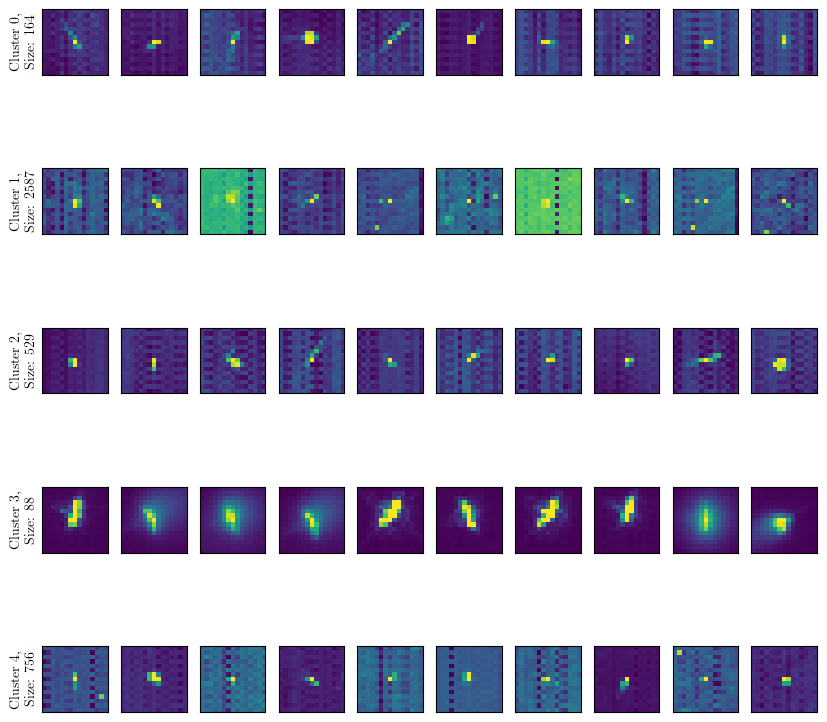

In [38]:
# Apply PCA with 2 components.
pca = PCA(n_components=2)
pca_images = pca.fit_transform(scaled_images)

# K-means parameters.
CRITERIA = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 1000, 0.01)
CLUSTERS = 5
ATTEMPTS = 12

# Run model.
compactness_6npca, labels_6npca, centroids_6npca = k_means_nn(pca_images, CLUSTERS, ATTEMPTS, CRITERIA)

# Display samples.
kmeans_sample(images, labels_6npca, 10, original_shape= 15)
print(f"Compactness: {compactness_6npca}")

Text(0.5, 1.0, 'PSFs clusters with 2 features.')

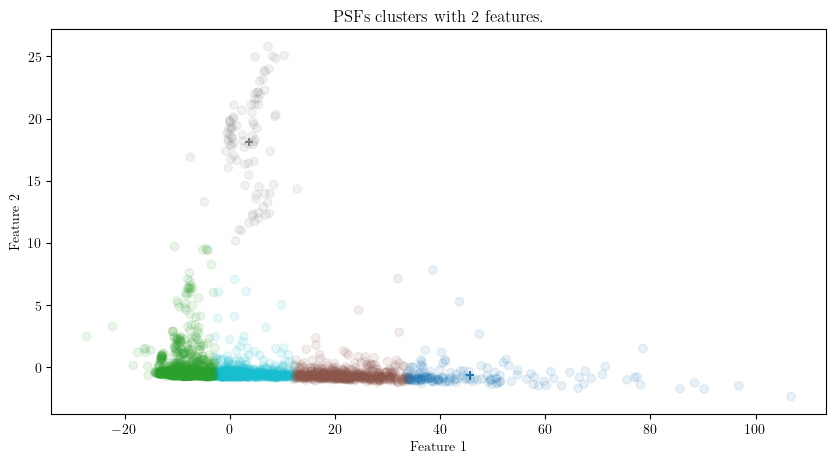

In [39]:
fig, axis = plt.subplots(1, 1, figsize = (10, 5))

axis.scatter(pca_images[:,0], pca_images[:,1],c = labels_6npca, cmap="tab10", alpha = 0.1)
axis.scatter(centroids_6npca[:,0], centroids_6npca[:,1], c = np.arange(5), cmap = "tab10", marker = "+")
axis.set_xlabel("Feature 1"), axis.set_ylabel("Feature 2")
axis.set_title("PSFs clusters with 2 features.")

Due to compatibility issues, save dataframe into parquet.

In [40]:
possible_objects["REGION_serialized"] = possible_objects["REGION"].apply(lambda x: x.tolist())
possible_objects.drop(columns=["REGION"]).to_parquet("possible_objects.parquet")

# **C. Autoencoder**

It is a network trained to attempt to copy its input to its output. Ir has a latent space that describes a code used to represent the input. Consists of an encoder and a decoder that produces the reconstruction of the input.

The learning process works by minimizing a loss function that penalizes the reconstruction function for being dissimilar from x.

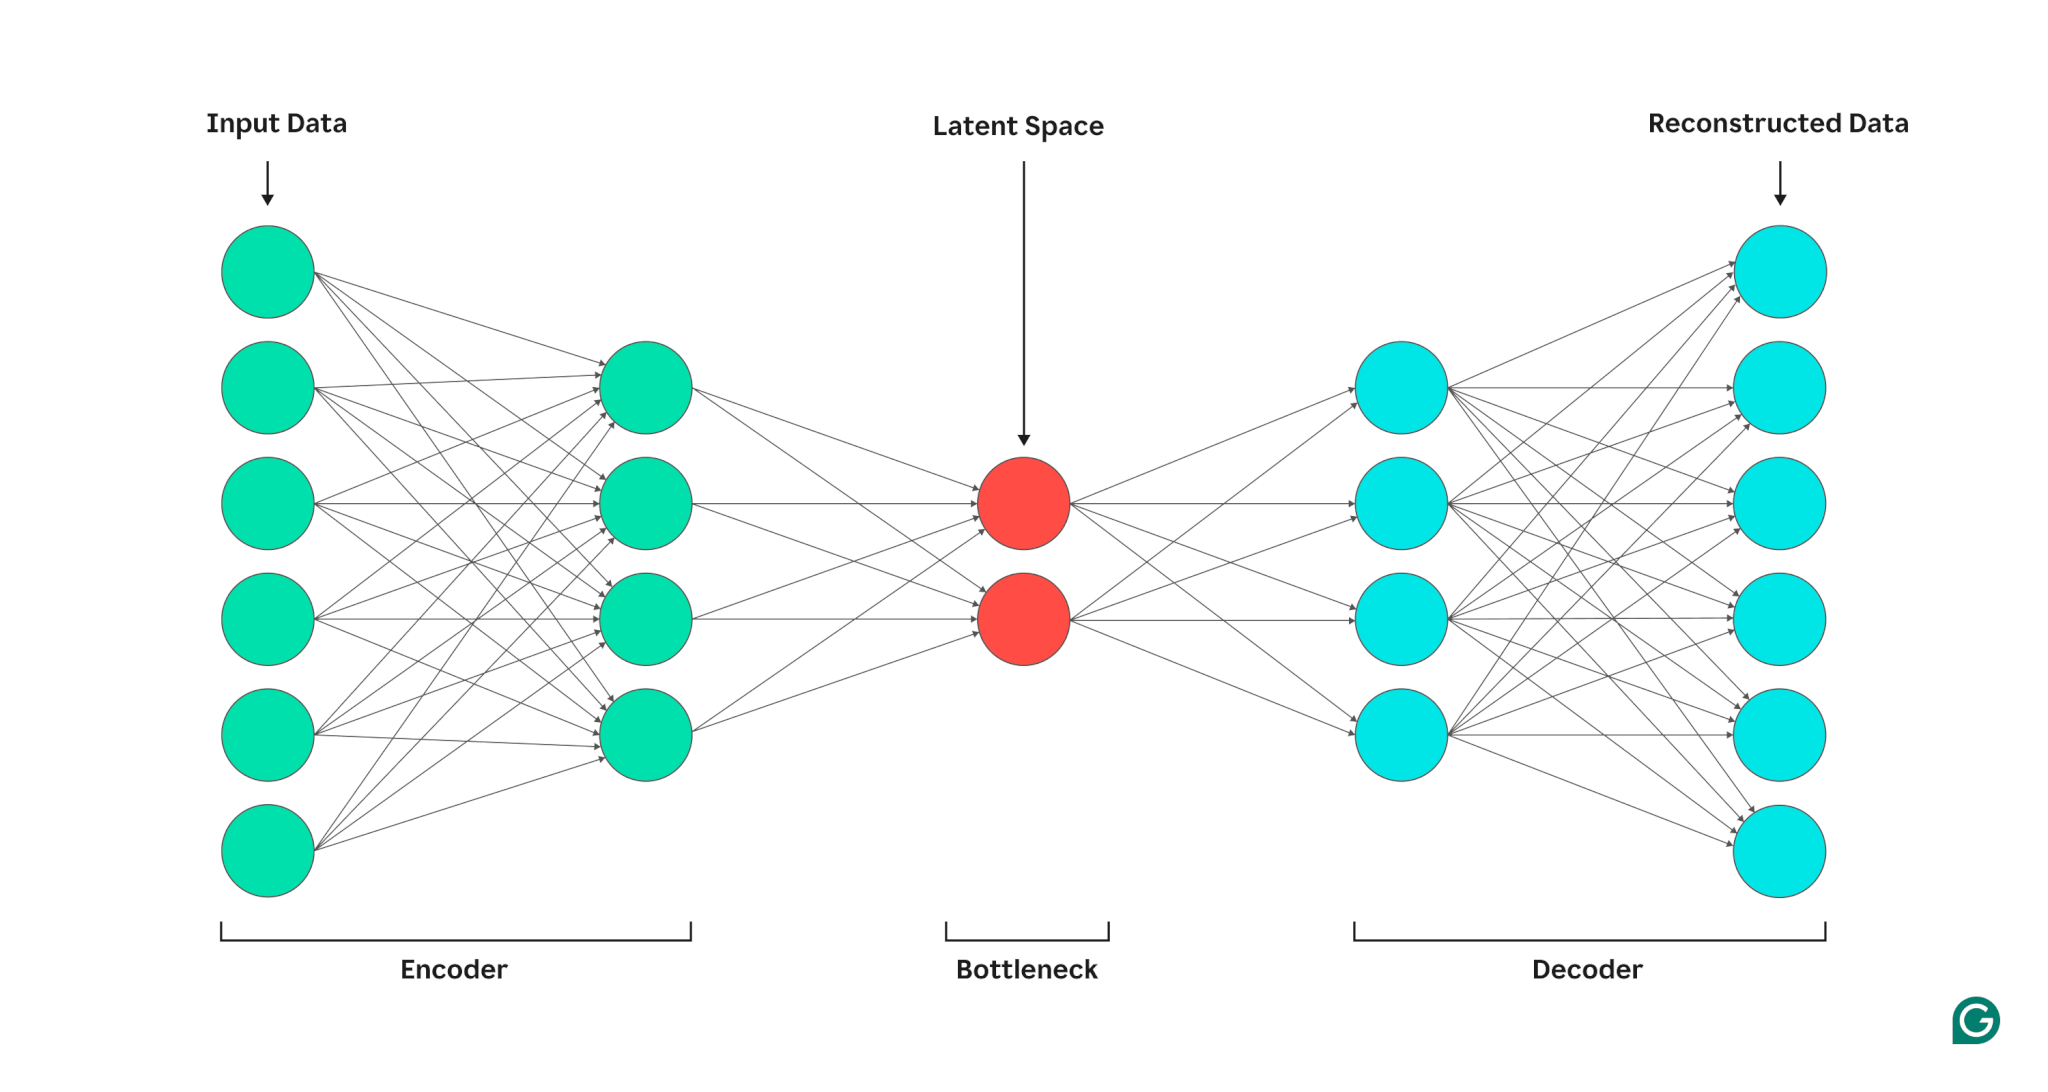

In [41]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np

## OBJECTS B

### 3.1. Data preparation and loading.

Load data and create list to be saved.

In [42]:
# Load objects from parquet file.
possible_objects = pd.read_parquet("possible_objects.parquet")
objects_list = possible_objects["REGION_serialized"]

# Save into list.
images = []
for i in range(len(objects_list)):
    img = objects_list.iloc[i]
    img = np.stack(img).astype(np.float32)
    img_norm = (img - img.min()) / (img.max() - img.min() + 1e-8)
    images.append(img_norm) 

In [43]:
class PSFDataset(Dataset):
    """
    Dataset class that loads 2d numpy arrays and creates torch tensor for machine learning training.

    Parameters:
        images (list) : list of 2d numpy arrays with PSFs images (15x15)
    """

    def __init__(self, psf_list):
        """
        Convert each image into a torch tensor and add a channel dimension.
        """

        self.data = [torch.tensor(img, dtype=torch.float32).unsqueeze(0) for img in psf_list]

    def __len__(self):
        """
        Return total number of samples in the dataset.
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Retrieve the PSF image at the specified index.
        """
        return self.data[idx]


### 3.2. Model creation.

Define the autoencoder architecture.

In [44]:
class PSFAutoencoder2(nn.Module):
    def __init__(self):
        super(PSFAutoencoder2, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1),   # (B,8,15,15)
            nn.ReLU(),
            nn.MaxPool2d(2),                             # (B,8,7,7)
            nn.Conv2d(8, 16, kernel_size=3, padding=1),  # (B,16,7,7)
            nn.ReLU(),
            nn.MaxPool2d(2)                              # (B,16,3,3)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 8, kernel_size=2, stride=2),  # (B,8,6,6)
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, kernel_size=2, stride=2),   # (B,1,12,12)
            nn.ReLU(),
            nn.Conv2d(1, 1, kernel_size=4, padding=1),           # (B,1,15,15)
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [45]:
import torch
import torch.nn as nn

class PSFAutoencoder(nn.Module):
    """
    Autoencoder architecture that reconstructs a given Point spread function.
    Learn the latent dimension of the samples.
    """

    def __init__(self, channel_a, latent_dim = 5):
        """
        Define encoder and decoder structure.
        """
        super(PSFAutoencoder, self).__init__()

        
        self.encoder = nn.Sequential(
            # (B, 1, 15, 15)
            nn.Conv2d(1, channel_a, kernel_size=3, padding=1),  
            # (B, channel_a, 15, 15)

            nn.ReLU(),
            nn.MaxPool2d(2, ceil_mode=True),
            # (B, channel_a, 8, 8)                               
            nn.Conv2d(channel_a, channel_a * 2, kernel_size=3, padding=1),  
            # (B, channel_a*2, 8, 8)
            nn.ReLU(),
            nn.MaxPool2d(2, ceil_mode=True)
            # (B, channel_a*2, 4, 4)   
        )                             
        
        self.encoder_dense = nn.Sequential(
            nn.Flatten(),
            nn.Linear((channel_a * 2) * 4 * 4, 24),
            nn.ReLU(),
            nn.Linear(24, latent_dim)
        )

        self.decoder_dense = nn.Sequential(
            nn.Linear(latent_dim, 24),
            nn.ReLU(),
            nn.Linear(24, (channel_a * 2) * 4 * 4),
            nn.Unflatten(1, (channel_a * 2, 4, 4))
        )


        self.decoder = nn.Sequential(
            # (B, channel_a*2, 4, 4)   
            nn.ConvTranspose2d(channel_a * 2, channel_a, kernel_size=2, stride=2),  
            # (B, channel_a, 8, 8) 
            nn.ReLU(),
            nn.ConvTranspose2d(channel_a, 1, kernel_size=2, stride=2),
            # (B, channel_a, 16, 16)                   
            nn.ReLU(),
            nn.Conv2d(1, 1, kernel_size=2)  
            # (B, 1, 16, 16)                                                  
            )


    def forward(self, x):
        """
        Forward pass of the autoencoder.

        Parameters:
            x (torch tensor): input tensor.
        Output:
            x (torch tensor): reconstructed tensor.ù
        """
        x = self.encoder(x)
        x = self.encoder_dense(x)
        x = self.decoder_dense(x)
        x = self.decoder(x)
        return x
    
    def get_latent(self, x):
        """
        Forward pass of the autoencoder and save the latent representation.
        """
        x = self.encoder(x)
        x = self.encoder_dense(x)
        return x



This function trains a convolutional autoenconder on a set of Point spread functions of shape (15, 15)

In [46]:

def train_autoencoder(psf_images, epochs=20, batch_size=16, lr=1e-3,
                     n_channels = 8, latent_dim = 5,  verbose = False):
    """
    Training funtion of the autoencoder architecture. Takes a normalized PSF image and 
    extract the latent dimension. Then, reconstruct the image and compute accuracy and loss.
    
    Parameters:
        psf_images (dataloader): list with images.
        epochs (int): number of epochs for training.
        batch_size (int): size of the batch.
        lr (float): learning rate for optimizer.
        n_channels (int): number of channels to be created in the convolutional layers.
        latent_dim (int): number of neurons for the latent dimension.
        verbose (bool): show training loss.
    Output:
        model (torch model): trained model.

    """
    # Use GPU.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load dataset.
    dataset = PSFDataset(psf_images)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Run model
    model = PSFAutoencoder(channel_a=n_channels, latent_dim= latent_dim).to(device)
    # Define optimizer.
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # Measure pixel wise mean squared error between input and output.
    criterion = nn.MSELoss()
    loss_values = []
    # Iterate for epochs.
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        # Iterate for batches.
        for batch in dataloader:
            # Send batch to GPU.
            batch = batch.to(device)
            # Forward pass.
            output = model(batch)
            # Compare original image with reconstructed sample.
            loss = criterion(output, batch)
            # Reset gradients.
            optimizer.zero_grad()
            # Backpropagation.
            loss.backward()
            # Update weights.
            optimizer.step()

            total_loss += loss.item()
            
        if verbose:
            print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss/len(dataloader):.6f}")
        loss_values.append(total_loss/len(dataloader))
    
    print(f"Training finished.")
    
    return model, loss_values


### 3.3. Train model

Training finished.


Text(0.5, 1.0, 'Autoencoder training.')

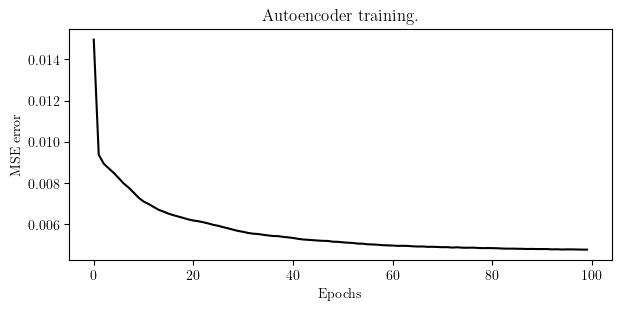

In [47]:
# Train model
model, loss = train_autoencoder(images,epochs=100, n_channels= 8,latent_dim= 20, verbose= False)

# Display loss.
fig, axis = plt.subplots(1, 1, figsize = (7, 3))
axis.plot(loss, color = "black")
axis.set_xlabel("Epochs")
axis.set_ylabel("MSE error")
axis.set_title("Autoencoder training.")

Display samples.

In [52]:
def display_samples_ae(model, images, n_samples):
    """
    Display original samples vs reconstructed samples retrieved from an autoencoder.

    Parameters:
        model (torch model): trained autoencoder model.
        images (torch dataset): torch images.
        n_samples (int): number of samples to show.
    """

    # Create plot.
    fig, axis = plt.subplots(2, n_samples, figsize = (15, 3))
    # Take random indexes.
    indexes = np.random.randint(0, len(images), n_samples)

    for i in range(n_samples):
        # Take image from sample.
        sample = images[i].unsqueeze(0)
        device = next(model.parameters()).device
        # Send sample to GPU.
        sample = sample.to(device)
        # Get reconstruction
        with torch.no_grad():
            # Run model.
            reconstructed = model(sample)

        # Convert back to NumPy for plotting
        original_np = sample.squeeze().cpu().numpy()
        reconstructed_np = reconstructed.squeeze().cpu().numpy()   

        axis[0,i].imshow(original_np)
        axis[1,i].imshow(reconstructed_np)
        axis[0,i].set_xticks([]), axis[0,i].set_yticks([])
        axis[1,i].set_xticks([]), axis[1,i].set_yticks([])

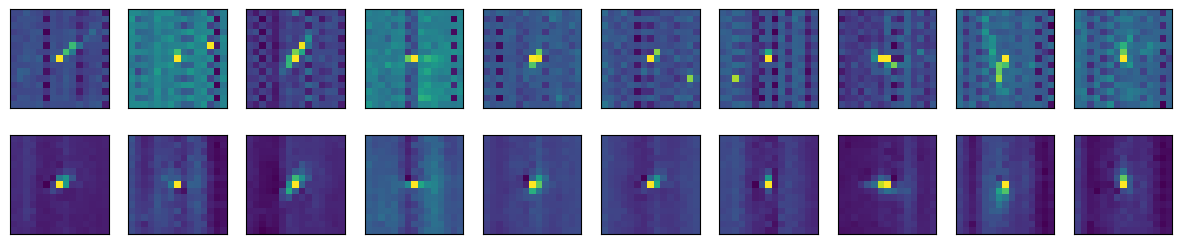

In [53]:
display_samples_ae(model, PSFDataset(images), 10)

## 3.4. Extract latent dimension.

In [50]:
def extract_latents(model, psf_images, batch_size=32):
    """
    Extract latent dimension from the images using a trained model. 

    Parameters:
        model (torch model): previously trained model.
        psf_images (images): images with samples
        batch_size (int): size of the batch.

    Output:
        latents_array (array): extracted features of the images.
    """
    model = model.to("cuda")
    model.eval()

    dataset = PSFDataset(psf_images)  
    dataloader = DataLoader(dataset, batch_size=batch_size)

    all_latents = []

    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to("cuda")
            latents = model.get_latent(batch)  
            all_latents.append(latents.cpu().numpy())

    latents_array = np.concatenate(all_latents, axis=0)
    return latents_array



In [51]:
features = extract_latents(model, images, 32)
features.shape

(4124, 20)

**K Means**

Compactness: 0.5862769644099899


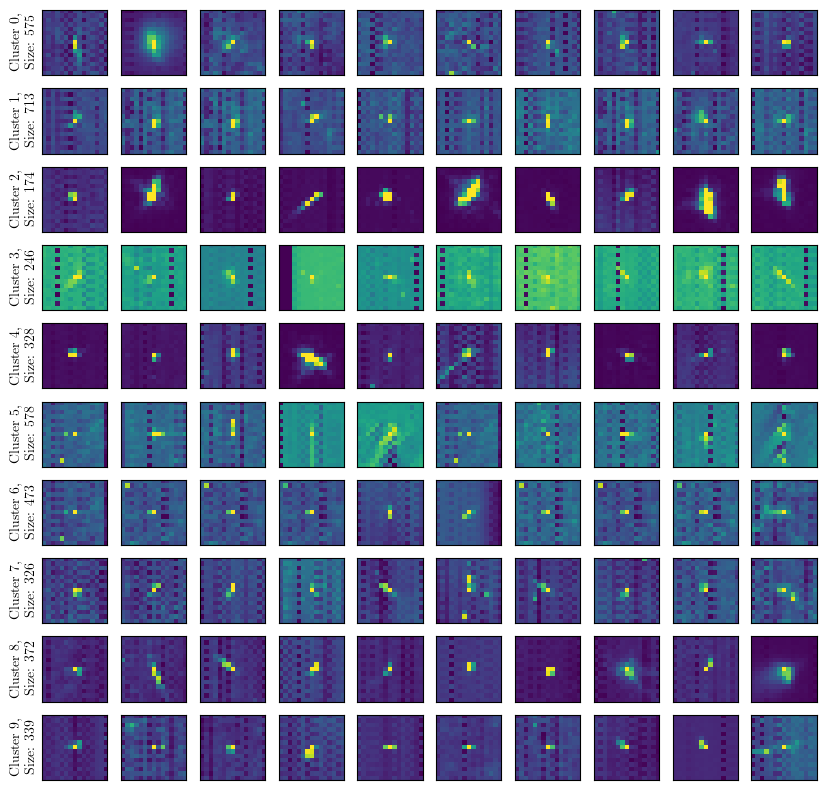

In [76]:

# K-means parameters.
CRITERIA = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 1000, 0.01)
CLUSTERS = 10
ATTEMPTS = 12

# Run model.
compactness_1pca, labels_1pca, centroids_1pca = k_means_nn(features, CLUSTERS, ATTEMPTS, CRITERIA)

# Display samples.
kmeans_sample(images, labels_1pca, 10, original_shape= 15)
print(f"Compactness: {compactness_1pca}")

Compactness: 0.7187836782268278


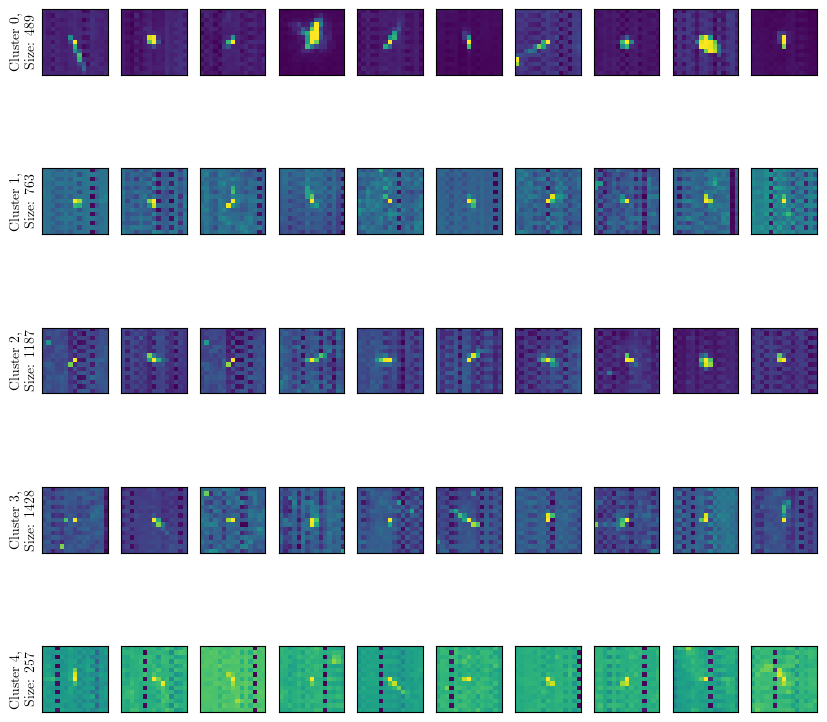

In [77]:

# K-means parameters.
CRITERIA = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 1000, 0.01)
CLUSTERS = 5
ATTEMPTS = 12

# Run model.
compactness_1pca, labels_1pca, centroids_1pca = k_means_nn(features, CLUSTERS, ATTEMPTS, CRITERIA)

# Display samples.
kmeans_sample(images, labels_1pca, 10, original_shape= 15)
print(f"Compactness: {compactness_1pca}")

Compactness: 0.12593022401287512


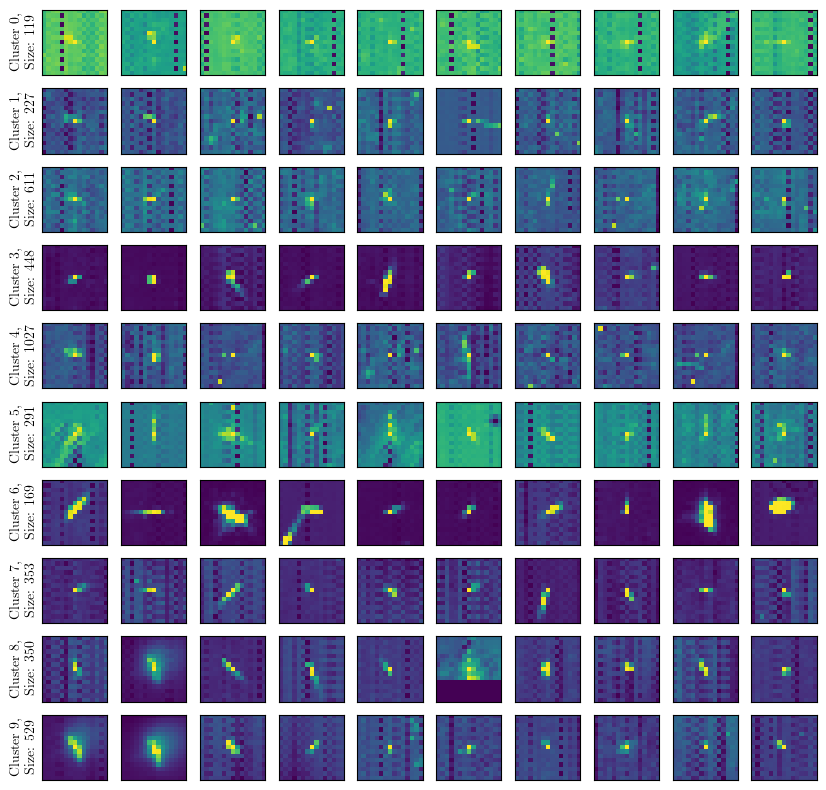

In [78]:
# Apply PCA with 10 components.
from sklearn.decomposition import PCA

pca = PCA(n_components= 2)
pca_images = pca.fit_transform(features)

# K-means parameters.
CRITERIA = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 1000, 0.01)
CLUSTERS = 10
ATTEMPTS = 12

# Run model.
compactness_1pca, labels_1pca, centroids_1pca = k_means_nn(pca_images, CLUSTERS, ATTEMPTS, CRITERIA)

# Display samples.
kmeans_sample(images, labels_1pca, 10, original_shape= 15)
print(f"Compactness: {compactness_1pca}")


Text(0.5, 1.0, 'PSFs clusters with 2 features.')

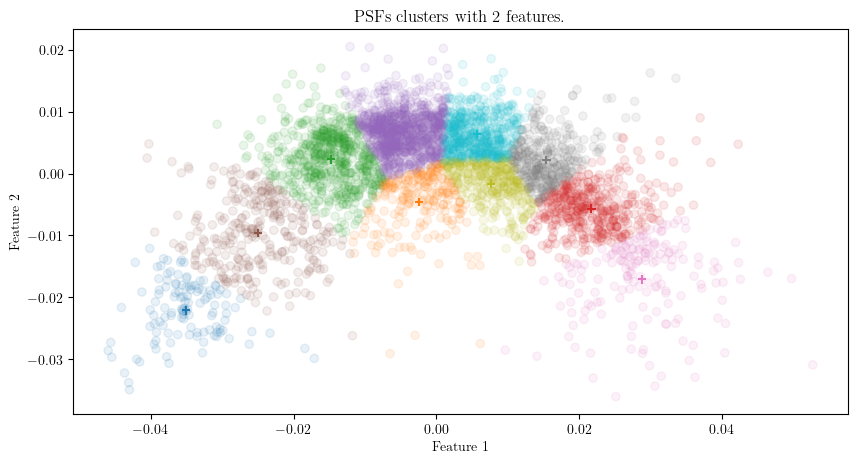

In [79]:
fig, axis = plt.subplots(1, 1, figsize = (10, 5))

axis.scatter(pca_images[:,0], pca_images[:,1],c = labels_1pca, cmap="tab10", alpha = 0.1)
axis.scatter(centroids_1pca[:,0], centroids_1pca[:,1], c = np.arange(10), cmap = "tab10", marker = "+")
axis.set_xlabel("Feature 1"), axis.set_ylabel("Feature 2")
axis.set_title("PSFs clusters with 2 features.")

**DBSCAN**

Knee detected at: 0.017526589334011078


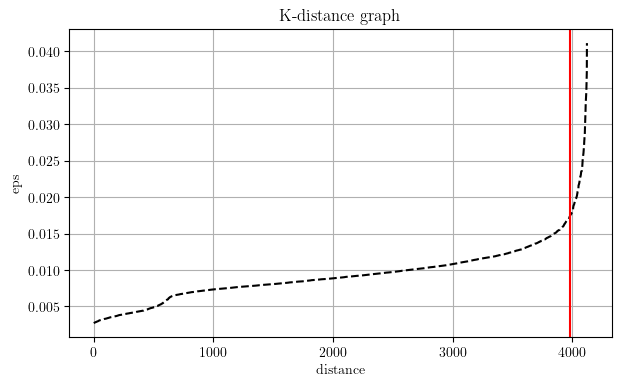

In [80]:
MIN_SAMPLES = 30
distances, eps = dbscan_eps_finder(features, MIN_SAMPLES )

# Display plot.
fig, axis = plt.subplots(1, 1, figsize = (7, 4))
axis.plot(distances, color = "black", linestyle = "dashed")
axis.set_title("K-distance graph")
axis.set_xlabel("distance")
axis.set_ylabel("eps")
axis.grid()
axis.axvline(eps, color = "red")
print(f"Knee detected at: {distances[eps]}")

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

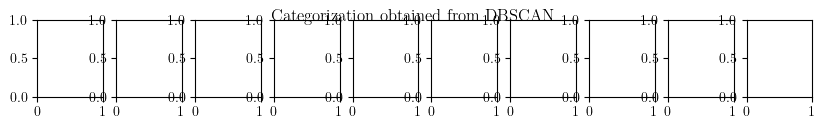

In [81]:
# Run DBSCAN
EPS = 4
MIN_SAMPLES = 30
labels = dbscan(features, EPS, MIN_SAMPLES)

dbscan_samples(images, labels, 10, 15)

Knee detected at: 1.7854690451179334


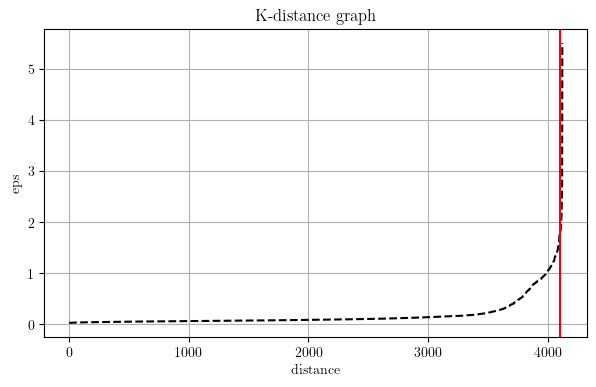

In [ ]:
MIN_SAMPLES = 10
distances, eps = dbscan_eps_finder(features, MIN_SAMPLES )

# Display plot.
fig, axis = plt.subplots(1, 1, figsize = (7, 4))
axis.plot(distances, color = "black", linestyle = "dashed")
axis.set_title("K-distance graph")
axis.set_xlabel("distance")
axis.set_ylabel("eps")
axis.grid()
axis.axvline(eps, color = "red")
print(f"Knee detected at: {distances[eps]}")

No enough samples for cluster: -1
No enough samples for cluster: -1
No enough samples for cluster: -1
No enough samples for cluster: -1
No enough samples for cluster: -1
No enough samples for cluster: -1
No enough samples for cluster: -1
No enough samples for cluster: -1


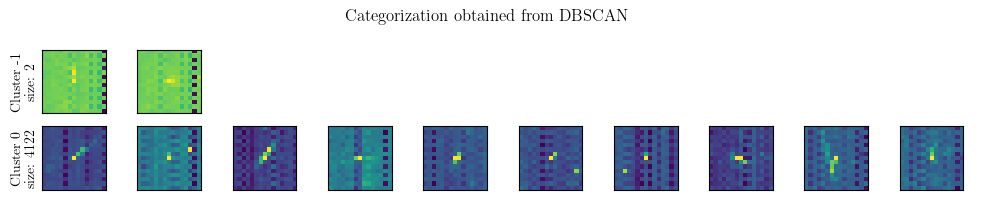

In [ ]:
# Run DBSCAN
EPS = 2
MIN_SAMPLES = 10
labels = dbscan(features, EPS, MIN_SAMPLES)

dbscan_samples(images, labels, 10, 15)

In [ ]:
gaussian mixture models


Apply PCA.

## 4. Extract statistical features.

In [ ]:

def extract_stats_features(img):
    """
    Extract statitstical features from the samples for clustering.

    Parameters:
        img (2d array): numpy array with PSFs image.
    
    Output:
        mean
        std
        max
        min
        median
        sum
        var
    """
    return [
        np.mean(img),
        np.std(img),
        np.max(img),
        np.min(img),
        np.median(img),
        np.sum(img),
        np.var(img)
    ]

In [ ]:
features = np.array([extract_stats_features(img) for img in images])

# Apply k-means method.
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 1000, 0.01)
CLUTERS = 5
compactness, labels, centers = cv2.kmeans(data=features.astype(np.float32),
                                          K=CLUTERS,
                                          bestLabels=None,
                                          criteria=criteria,
                                          attempts=12,
                                          flags=cv2.KMEANS_PP_CENTERS)
pairs = list(zip(images, labels))

In [ ]:
dbscan = DBSCAN(eps = 1000, min_samples= 10)
labels_db = dbscan.fit_predict(features)

pairs = list(zip(images, labels_db))

pd.DataFrame(labels_db, columns = ["index"]).groupby("index").size()


index
-1     4734
 0     4196
 1       60
 2       89
 3       17
 4       42
 5       43
 6       32
 7       22
 8       15
 9       68
 10      19
 11      24
 12      32
 13      15
 14       8
 15      34
 16       8
 17      10
 18      10
 19      15
 20      18
 21       8
dtype: int64

IndexError: index 3 is out of bounds for axis 0 with size 3

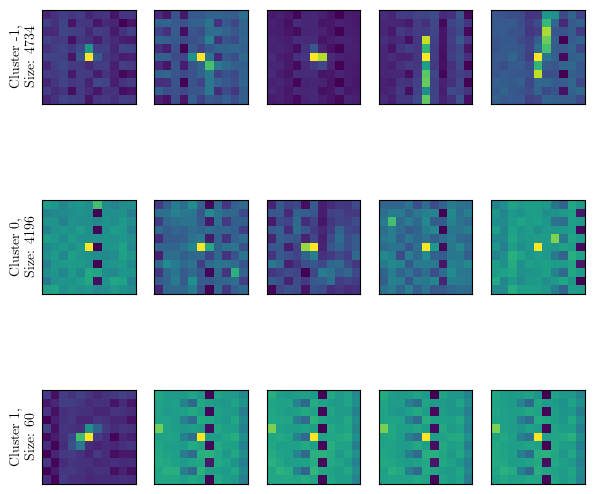

In [ ]:
# Display images by labels.
samples_number = 5
CLUTERS = 3 
fig, axis = plt.subplots(CLUTERS, samples_number, figsize = (7, 7))

# Extract cluster index.
labels = np.unique(labels_db)

for idx, cli in enumerate(labels):
    samples = [img.reshape(11,11) for img, lbl in pairs if lbl == cli]
    samples_r = random.sample(samples, samples_number)
    axis[idx,0].set_ylabel(f"Cluster {cli}, \n Size: {len(samples)}")
    for j in range(samples_number):
        axis[idx, j].imshow(samples_r[j])
        axis[idx, j].set_xticks([])
        axis[idx, j].set_yticks([])

Load samples.

In [ ]:
# Load objects.
OBJECTS_2 = pd.read_pickle("possible_objects.pkl")

# Display size.
print(f"Number of obtained objects: {len(OBJECTS_2)}")

Number of obtained objects: 4124


Display some samples.

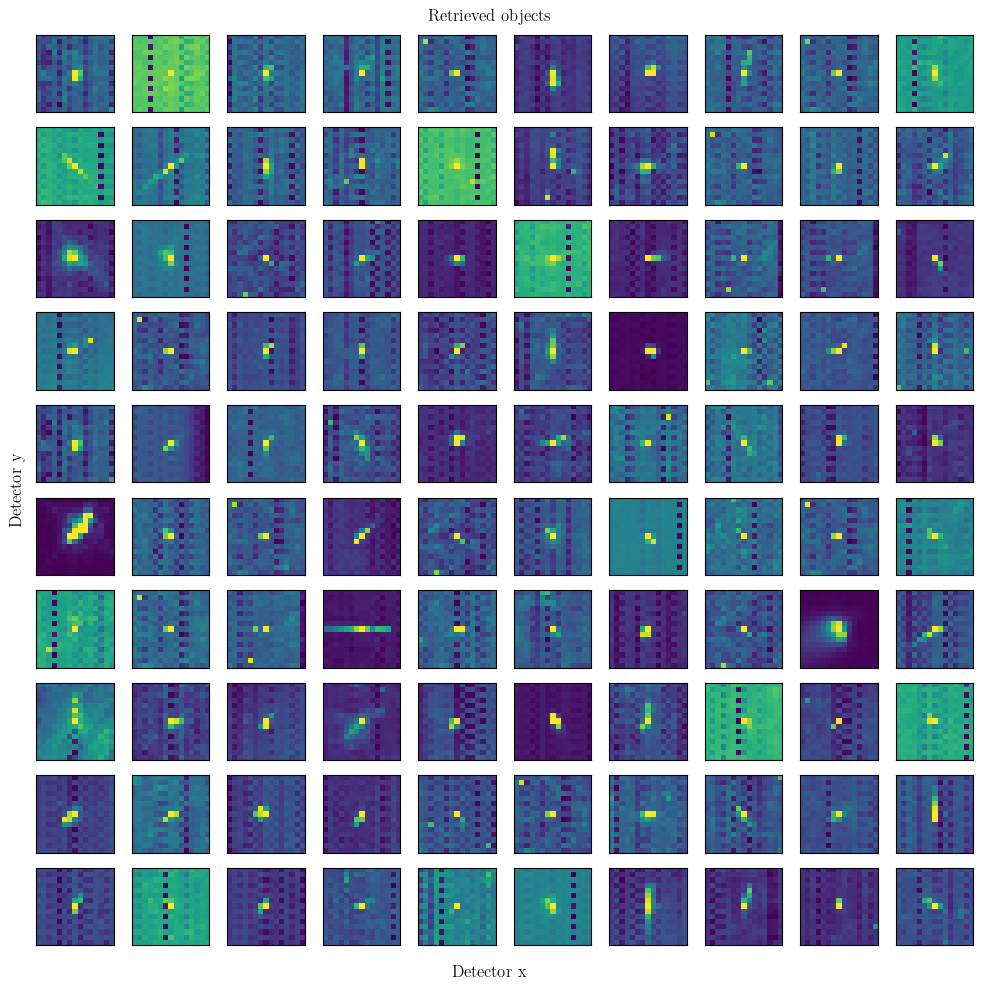

In [ ]:
# Load objects.
fig, axis = plt.subplots(10, 10, figsize = (10, 10))
fig.suptitle("Retrieved objects")
fig.supxlabel("Detector x")
fig.supylabel("Detector y")
axis = axis.flatten()
# Take randomly objects.
samples = OBJECTS_2.sample(100)
for i in range(100):
    axis[i].imshow(samples["REGION"].iloc[i])
    axis[i].set_xticks([]), axis[i].set_yticks([])

plt.tight_layout()

## 1. K-means

In [ ]:
# Flatten images
images = np.array(OBJECTS_2["REGION"].apply(lambda x: x.flatten()).to_list())

# Apply k-means method.
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 1000, 0.01)
CLUTERS = 4
compactness, labels, centers = cv2.kmeans(data=images.astype(np.float32),
                                          K=CLUTERS,
                                          bestLabels=None,
                                          criteria=criteria,
                                          attempts=12,
                                          flags=cv2.KMEANS_PP_CENTERS)
pairs = list(zip(images, labels))

ValueError: cannot reshape array of size 225 into shape (11,11)

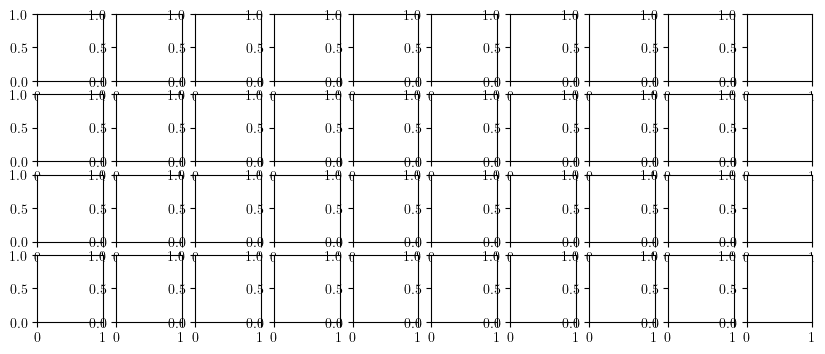

In [ ]:
display_allsamples(pairs, 10, len(centers))